# Create gridded SIF residuals for 2016-07 using lon, lat, and evi covariates

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import xarray as xr
import xesmf as xe
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf

from cmcrameri import cm
import seaborn as sns
import plot

In [3]:
# read in the sif data and evi covariate
extents = {"lon0_b": -125, "lon1_b": -65, "lat0_b": 22, "lat1_b": 58}
with xr.open_dataset("../data/exp_pro/MODIS_EVI_conus.nc") as ds:
    ds_evi = ds.sel(time="2016-07").squeeze()
    bounds = (
        (ds.lon >= extents["lon0_b"])
        & (ds.lon <= extents["lon1_b"])
        & (ds.lat >= extents["lat0_b"])
        & (ds.lat <= extents["lat1_b"])
    )
    ds_evi = ds_evi.where(bounds, drop=True)


with xr.open_dataset("005_deg_gridded_sif_201607.nc") as ds_sif:
    # EVI dataset is oriented with latitude in decreasing order; flip to match SIF dataset
    ds_sif["evi"] = (["lon", "lat"], np.fliplr(ds_evi["evi"].values).astype(np.float64))
    
ds_sif

<xarray.Dataset>
Dimensions:  (lon: 1200, lat: 720)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.9 -124.8 ... -65.13 -65.08 -65.03
  * lat      (lat) float64 22.02 22.08 22.12 22.18 ... 57.83 57.88 57.93 57.98
Data variables:
    sif      (lon, lat) float64 ...
    evi      (lon, lat) float64 nan nan nan ... 2.901e+07 2.901e+07 3.003e+07

In [4]:
df = ds_sif.to_dataframe().reset_index()[["lon", "lat", "evi", "sif"]].dropna(how="any")

# standardize the covariates
X = df[["lon", "lat", "evi"]].values
df[["lon_std", "lat_std", "evi_std"]] = (X - X.mean(axis=0)) / X.std(ddof=1, axis=0)

df.head()


,lon,lat,evi,sif,lon_std,lat_std,evi_std
574,-124.975,50.725,44250000.0,0.546097,-1.703429,0.779499,0.439474
575,-124.975,50.775,43360000.0,0.112822,-1.703429,0.785227,0.383525
576,-124.975,50.825,43640000.0,0.418302,-1.703429,0.790956,0.401127
577,-124.975,50.875,48060000.0,0.401056,-1.703429,0.796684,0.678987
578,-124.975,50.925,46360000.0,0.401562,-1.703429,0.802412,0.572118


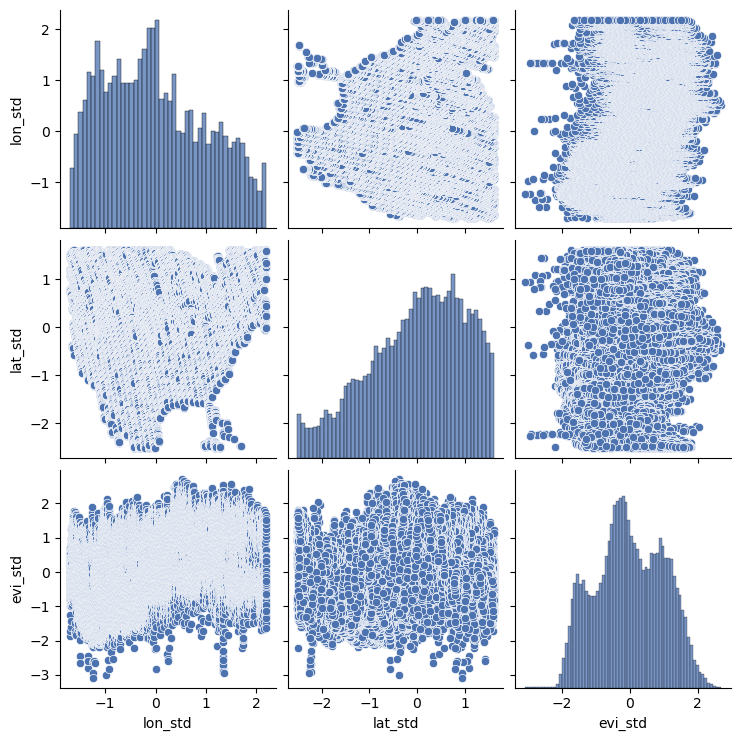

In [5]:
sns.pairplot(df[["lon_std", "lat_std", "evi_std"]])

In [6]:
model = smf.ols(formula="sif ~ np.power(lat_std, 2)*np.power(lon_std, 2) + evi_std", data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    sif   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                 2.500e+04
Date:                Tue, 13 Sep 2022   Prob (F-statistic):               0.00
Time:                        08:40:42   Log-Likelihood:                 11611.
No. Observations:               48715   AIC:                        -2.321e+04
Df Residuals:                   48710   BIC:                        -2.317e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     0.4967      0.002    313.683      0.000       0.494       0.500
np.power(lat_std, 2)                         -0.0294      0.001    -32.365      0.000      -0.031      -0.028
np.power(lon_std, 2)                         -0.0498      0.001    -44.418      0.000      -0.052      -0.048
np.power(lat_std, 2):np.power(lon_std, 2)     0.0123      0.001     14.295      0.000       0.011       0.014
evi_std                                       0.2658      0.001    301.932      0.000       0.264       0.267
==============================================================================
Omnibus:                    13813.220   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           412149.185
Skew:                           0.750   Prob(JB):                         0.00
Kurtosis:                      17.170   Cond. No.                         5.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# covariates = df[["lon_std", "lat_std", "evi_std"]].copy()
# model = LinearRegression().fit(covariates, df["sif"])
# df["ols_mean"] = model.predict(covariates)
df["ols_mean"] = model.predict()
df["sif_residuals"] = df["sif"] - df["ols_mean"]
df

,lon,lat,evi,sif,lon_std,lat_std,evi_std,ols_mean,sif_residuals
574,-124.975,50.725,44250000.0,0.546097,-1.703429,0.779499,0.439474,0.472692,0.073405
575,-124.975,50.775,43360000.0,0.112822,-1.703429,0.785227,0.383525,0.457878,-0.345057
576,-124.975,50.825,43640000.0,0.418302,-1.703429,0.790956,0.401127,0.462612,-0.044310
577,-124.975,50.875,48060000.0,0.401056,-1.703429,0.796684,0.678987,0.536513,-0.135457
578,-124.975,50.925,46360000.0,0.401562,-1.703429,0.802412,0.572118,0.508168,-0.106606
...,...,...,...,...,...,...,...,...,...
863949,-65.025,55.475,34870000.0,0.532294,2.188481,1.323676,-0.150192,0.269610,0.262685
863992,-65.025,57.625,32910000.0,0.070236,2.188481,1.569987,-0.273406,0.257786,-0.187550
863993,-65.025,57.675,27000000.0,0.013305,2.188481,1.575715,-0.644934,0.159578,-0.146273
863994,-65.025,57.725,21960000.0,-0.030751,2.188481,1.581443,-0.961769,0.075906,-0.106657


In [8]:
df[["ols_mean", "sif_residuals"]].describe()

,ols_mean,sif_residuals
count,48715.000000,4.871500e+04
mean,0.427424,1.893954e-15
std,0.273182,1.906585e-01
min,-0.411032,-1.496253e+00
25%,0.223112,-1.076926e-01
50%,0.419544,-8.193978e-03
75%,0.645041,9.823841e-02
max,1.197268,4.363843e+00


/home/jj829/sif-xco2-cokriging/l2_north_america/../src/plot.py:175: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("roma"))
  cmap.set_bad(color="red")


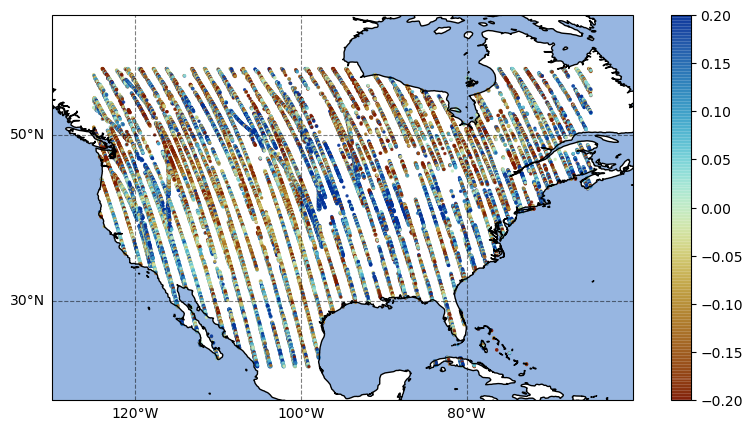

In [9]:
plot.plot_df(df, "sif_residuals", vmin=-0.2, vmax=0.2, cmap=cm.roma);

In [12]:
df.to_csv("gridded_sif_residuals_north_america.csv", index=False)